Loaded backend with 96 walkers and 5000 steps.
Autocorrelation times (steps): [509.7616984  436.45176997 541.25474658 473.16214083 512.75056466]


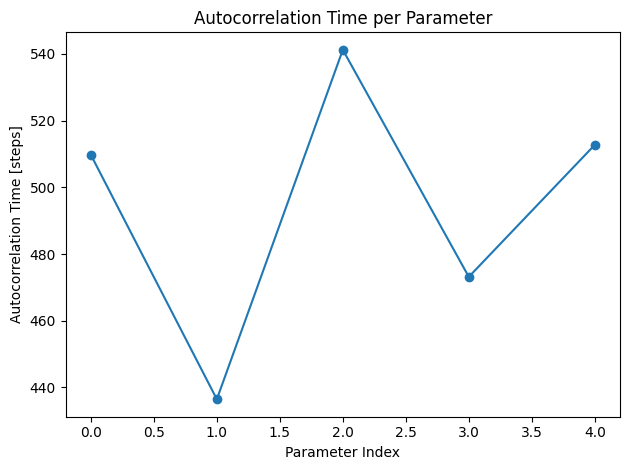

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
import h5py
import os
import os.path as osp

# === USER INPUTS ===
backend_file =  osp.expanduser("~/../../scratch/gpfs/cj1223/DIB/full_run.h5")  # <- replace with your emcee backend file
discard = 0  # number of burn-in steps to discard
thin = 10      # thinning factor for chains
flat = True    # whether to flatten the chain
max_autocorr_steps = 100  # how far to try computing autocorr
# ====================

# Load the backend
backend = emcee.backends.HDFBackend(backend_file, read_only=True)
n_steps, n_walkers, n_dim = backend.get_chain().shape
print(f"Loaded backend with {n_walkers} walkers and {n_steps} steps.")

# Check if there's enough data
if n_steps < 2 * discard:
    raise RuntimeError("Too few samples to discard burn-in.")

# Compute autocorrelation time
try:
    tau = backend.get_autocorr_time(tol=0, discard=discard)
    print("Autocorrelation times (steps):", tau)
except emcee.autocorr.AutocorrError:
    print("WARNING: Autocorrelation time could not be reliably estimated. Showing partial results.")
    tau = None

# Plot autocorrelation estimate per parameter (if possible)
if tau is not None:
    fig, ax = plt.subplots()
    ax.plot(tau, "o-")
    ax.set_xlabel("Parameter Index")
    ax.set_ylabel("Autocorrelation Time [steps]")
    ax.set_title("Autocorrelation Time per Parameter")
    plt.tight_layout()
    plt.show()

In [2]:
acceptance_fraction = backend.accepted / backend.iteration
# acceptance_fraction
backend.accepted

array([ 34.,  46.,  69.,  24.,  82.,  66.,  28.,  51.,  25.,  32.,  78.,
        85.,  71.,  24.,  34.,  24.,  34., 137.,  69.,  86.,  53.,  80.,
        37., 100.,  52.,  22.,  58.,  32.,  47.,  62.,  38.,  21.,  67.,
        53.,  16.,  44.,  48.,  26.,  89.,  71.,  79.,  84.,  43.,  14.,
        50.,  34.,  64.,  41.,  22.,  88.,  29., 112.,  30., 111.,  72.,
        41.,  11.,  78.,  97.,  44.,  42.,  34.,  49.,  47.,  31.,  47.,
        32.,  16.,  82.,  72.,  68.,  93.,  33.,  78.,  54., 102.,  93.,
        39.,  28.,  63.,  21.,  62.,  25.,  88.,  58.,  29.,  26.,  36.,
        58.,  42.,  65.,  23.,  81.,  83.,  64.,  68.])

In [3]:
backend.shape

(96, 5)

Loaded backend with 96 walkers, 5000 steps, 5 dimensions.


/home/cj1223/.conda/envs/torch-env/lib/python3.9/site-packages/emcee/autocorr.py:38: RuntimeWarning: invalid value encountered in divide
  acf /= acf[0]


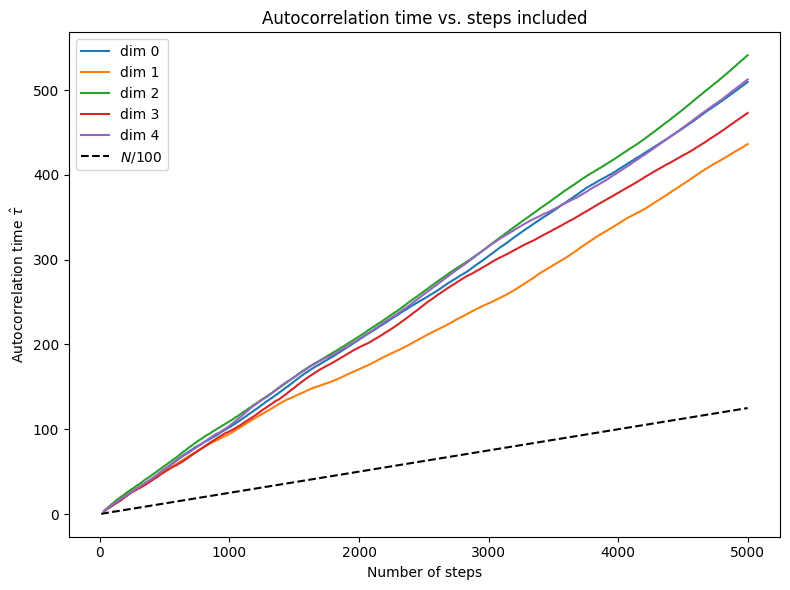

In [4]:
# === USER INPUTS ===
backend_file = osp.expanduser("~/../../scratch/gpfs/cj1223/DIB/full_run.h5")
discard = 0
thin = 1
step_stride = 10
min_steps = 10

# ====================

# Load backend and chain
backend = emcee.backends.HDFBackend(backend_file, read_only=True)
full_chain = backend.get_chain(discard=discard, thin=thin)
n_steps, n_walkers, n_dim = full_chain.shape
max_steps = n_steps+100
print(f"Loaded backend with {n_walkers} walkers, {n_steps} steps, {n_dim} dimensions.")

# Limit the max_steps to what's available
max_steps = min(max_steps, n_steps)

# Storage
all_taus = []
step_list = []

# Loop over truncated chains
for n in range(min_steps, max_steps + 1, step_stride):
    truncated = full_chain[:n]  # shape (n, n_walkers, n_dim)
    try:
        tau = emcee.autocorr.integrated_time(truncated, tol=0)
        all_taus.append(tau)
        step_list.append(n)
    except emcee.autocorr.AutocorrError:
        print(f"Step {n}: autocorr failed")
        continue

# Convert to arrays
all_taus = np.array(all_taus)  # shape (num_points, ndim)
step_list = np.array(step_list)

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
for i in range(n_dim):
    ax.plot(step_list, all_taus[:, i], label=f"dim {i}")
ax.plot(step_list, step_list / 40, "--k", label=r"$N/100$")

ax.set_xlabel("Number of steps")
ax.set_ylabel(r"Autocorrelation time $\hat{\tau}$")
ax.set_title("Autocorrelation time vs. steps included")
ax.legend()
plt.tight_layout()
plt.show()


Samples shape: (337536, 5)


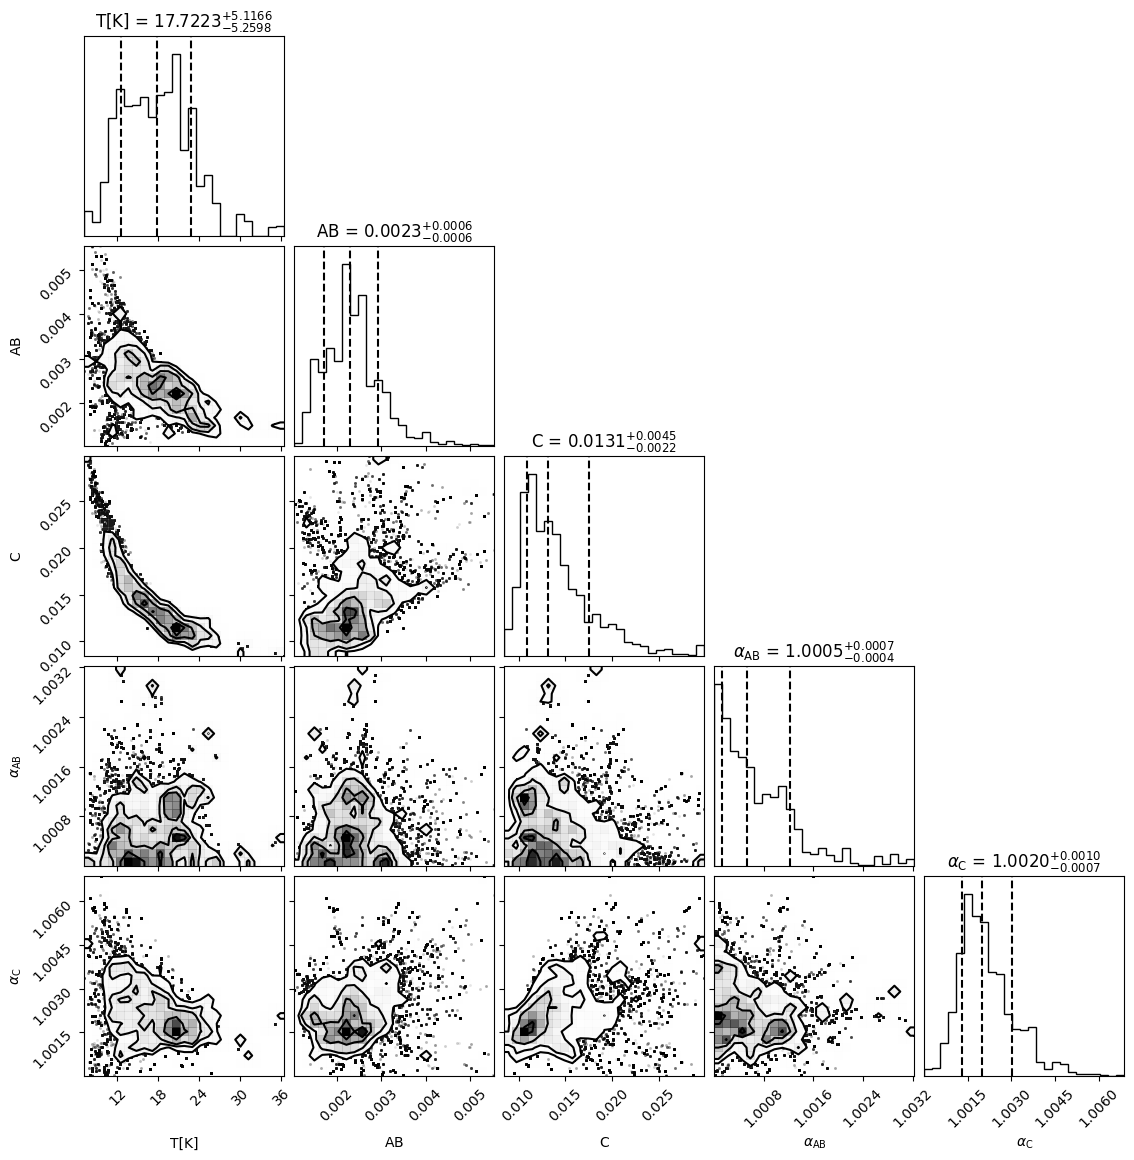

In [5]:
# Extract samples
thin = 1
discard = int( 3*np.mean(all_taus[-1, :]) )
samples = backend.get_chain(discard=discard, thin=thin, flat=flat)
log_prob = backend.get_log_prob(discard=discard, thin=thin, flat=flat)

print(f"Samples shape: {samples.shape}")

labels = [r'$\alpha_{\mathrm{C}}$', r'$\alpha_{\mathrm{AB}}$', r'$\mathrm{C}$', r'$\mathrm{AB}$', 'T[K]']
# Corner plot
fig = corner.corner(
    samples,
    labels=labels[::-1],
    bins = 25,
    show_titles=True,
    smooth = 0.6,
    quantiles=[0.16, 0.5, 0.84],
    title_fmt=".4f",
    range = [0.99999]*len(labels)
)
plt.show()


In [4]:
print(labels[::-1])

['T[K]', '$\\mathrm{AB}$', '$\\mathrm{C}$', '$\\alpha_{\\mathrm{AB}}$', '$\\alpha_{\\mathrm{C}}$']


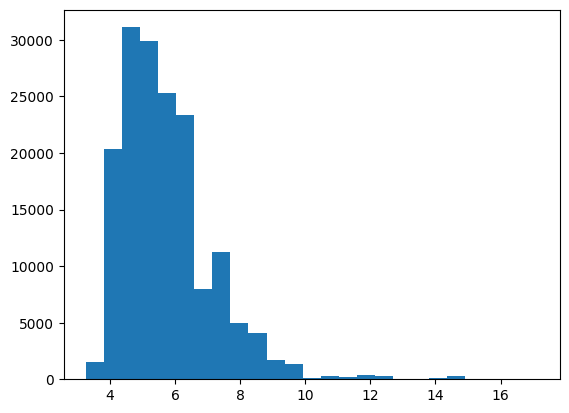

In [5]:
plt.hist(samples[:,2]/samples[:,1], bins = 25);

In [50]:
# np.savetxt(osp.expanduser("~/../../scratch/gpfs/cj1223/DIB/emcee_orig_2276.txt"), samples)
errs = h5py.File('jackknife_dib.h5', "r")
errs['cov']

<HDF5 dataset "cov": shape (143, 143, 4), type "<f8">

In [79]:

# === USER INPUTS ===
backend_dir =  osp.expanduser("~/../../scratch/gpfs/cj1223/DIB/")
fs = [f for f in os.listdir(backend_dir) if '.h5' in f]
print(fs)
backend_file = backend_dir+fs[-2]

savetest = emcee.backends.HDFBackend(backend_file, read_only=True)
savetest, backend_file

['full_run_ATrue_F5p0_DTrue_FlatFalse_SpecTrue_dTTrue_covFalse).h5', 'full_run_ATrue_F5p0_DTrue_FlatFalse_SpecTrue_dTTrue_covFalse.h5', 'full_run.h5', 'test_backend.h5', 'full_run_ATrue_F5p0_DTrue_FlatFalse_SpecTrue_dTTrue_covTrue.h5', 'full_run_ATrue_F5p0_DTrue_FlatFalse_SpecTrue_dTTrue.h5']


(<emcee.backends.hdf.HDFBackend at 0x1461600d6bb0>,
 '/home/cj1223/../../scratch/gpfs/cj1223/DIB/full_run_ATrue_F5p0_DTrue_FlatFalse_SpecTrue_dTTrue_covTrue.h5')

In [80]:
help(savetest)

Help on HDFBackend in module emcee.backends.hdf object:

class HDFBackend(emcee.backends.backend.Backend)
 |  HDFBackend(filename, name='mcmc', read_only=False, dtype=None, compression=None, compression_opts=None)
 |  
 |  A backend that stores the chain in an HDF5 file using h5py
 |  
 |  .. note:: You must install `h5py <http://www.h5py.org/>`_ to use this
 |      backend.
 |  
 |  Args:
 |      filename (str): The name of the HDF5 file where the chain will be
 |          saved.
 |      name (str; optional): The name of the group where the chain will
 |          be saved.
 |      read_only (bool; optional): If ``True``, the backend will throw a
 |          ``RuntimeError`` if the file is opened with write access.
 |  
 |  Method resolution order:
 |      HDFBackend
 |      emcee.backends.backend.Backend
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, filename, name='mcmc', read_only=False, dtype=None, compression=None, compression_opts=None)
 |      Ini

In [81]:
savetest.has_blobs()

True

In [82]:
savetest.get_blobs()

array([[[ -10.14300754,   -0.80992907, -320.43160937],
        [ -10.20671312,   -0.86491218, -327.7588649 ],
        [  -9.69579412,   -0.81180869, -272.55875955],
        [  -9.90431054,   -0.82769876, -282.24753771],
        [ -10.45742618,   -0.79785414, -250.47289026],
        [ -10.69978543,   -0.90516938, -336.47621643],
        [  -9.80328184,   -0.83378769, -296.90779802],
        [ -10.66860517,   -0.7325403 , -167.61169021],
        [ -10.66136811,   -0.91491579, -355.76997437],
        [  -9.33706346,   -0.78601116, -281.27508665],
        [ -10.80749676,   -0.89462514, -325.77648816],
        [  -9.54499183,   -0.68752043, -161.96203846],
        [ -10.97287838,   -0.89968236, -307.24932165],
        [  -8.89954343,   -0.68543397, -202.10531857],
        [ -11.13739769,   -0.94436094, -349.33043037],
        [ -10.39369846,   -0.87479008, -284.94543714]],

       [[ -10.14300754,   -0.80992907, -320.43160937],
        [ -10.20671312,   -0.86491218, -327.7588649 ],
        

In [83]:
savetest.get_log_prob()

array([[ -4641.16239699,  -2919.0645696 ,  -5910.4140929 ,
         -3268.83362163,  -5104.23378588,  -1844.37298709,
         -3033.03055349, -16989.52404025,  -2411.76454878,
         -4311.71292376,  -1987.77671781, -13062.36304148,
         -1994.77403073, -16194.56708884,  -2033.29728293,
         -2271.57146261],
       [ -4641.16239699,  -2919.0645696 ,  -5910.4140929 ,
         -3268.83362163,  -5104.23378588,  -1844.37298709,
         -3033.03055349, -13845.85762075,  -2158.73870983,
         -4311.71292376,  -1987.77671781, -13062.36304148,
         -1994.77403073, -16194.56708884,  -2033.29728293,
         -2271.57146261],
       [ -4641.16239699,  -2733.35427058,  -4294.51919809,
         -3268.83362163,  -5104.23378588,  -1844.37298709,
         -3033.03055349,  -3054.32723678,  -2158.73870983,
         -3321.83312764,  -1838.71345149, -13062.36304148,
         -1994.77403073,  -9480.61328464,  -2033.29728293,
         -2271.57146261],
       [ -4641.16239699,  -2733.35427

In [84]:
np.std(savetest.get_log_prob(), axis = 0)

array([ 929.43548609,  308.78170649, 1033.58711615,  287.89556678,
       1095.04726267,   22.15425198,  219.11005955, 5541.9737951 ,
         79.51834957,  467.10635689,  123.99291313, 3461.19748226,
        241.99726429, 4799.3388437 ,  198.53963864,  164.70189319])

In [86]:
savetest.accepted

array([3., 6., 4., 4., 8., 2., 4., 7., 4., 5., 8., 2., 5., 5., 5., 4.])